In [14]:
import pycocotools
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

import torch
from torch import nn
import torch.utils.data
import torchvision.models as models
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

import requests
import os
import pandas as pd

In [15]:
from python.engine import train_one_epoch, evaluate
import python.utils
import python.transforms as T

In [3]:
def parse_one_annot(path):
    data = {}
    for i,e in enumerate(os.listdir(path)):
        data_bach = pd.read_csv(os.path.join(path,e))
        data_bach = data_bach.values[0]
        x1 = int((data_bach[0].split(" ")[0]).split(".")[0])
        y1 = int((data_bach[0].split(" ")[1]).split(".")[0])
        x2 = int((data_bach[0].split(" ")[2]).split(".")[0])
        y2 = int((data_bach[0].split(" ")[3]).split(".")[0])
        data[e] = [x1,y1,x2,y2]
    return data

In [4]:
a = parse_one_annot("Label")
a['0.csv']

[165, 105, 298, 238]

[[165, 105, 298, 238]]


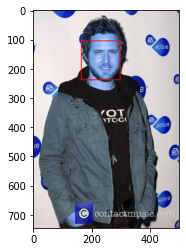

In [3]:
img = cv2.imread(os.path.join("Image","0.jpg"))
for row in df.iterrows():
    x1 = int((row[1][0].split(" ")[0]).split(".")[0])
    y1 = int((row[1][0].split(" ")[1]).split(".")[0])
    x2 = int((row[1][0].split(" ")[2]).split(".")[0])
    y2 = int((row[1][0].split(" ")[3]).split(".")[0])
    print([[x1,y1,x2,y2]])
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [6]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [7]:
##Test in 1 image

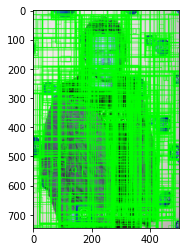

In [8]:
im = cv2.imread(os.path.join(path,"0.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    #print(x,y,w,h)
#    imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)


##If le carré vert est dans la tête de monsieur

In [9]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

##Fonction qui retour les point d'une face

In [10]:
def get_face(df):
    gtvalues=[]
    for row in df.iterrows():
        x1 = int((row[1][0].split(" ")[0]).split(".")[0])
        y1 = int((row[1][0].split(" ")[1]).split(".")[0])
        x2 = int((row[1][0].split(" ")[2]).split(".")[0])
        y2 = int((row[1][0].split(" ")[3]).split(".")[0])
        gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})

        return gtvalues    

In [11]:
train_images=[]
train_labels=[]

counter = 0
for e,i in enumerate(os.listdir(label)):
    try:
        filename = i.split(".")[0]+".jpg"
        image = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(label,i))
        gtvalues = get_face(df)
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = image.copy()
        flag = 0
        fflag = 0
        bflag = 0
        counter_false = True
        print(counter)
        if counter > 1000:
            break
        for e,result in enumerate(ssresults):
            if e < 2000 and flag == 0:
                for gtval in gtvalues:  
                    x,y,w,h = result
                    iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                    if iou > 0.70:
                        timage = imout[y:y+h,x:x+w]
                        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA).transpose(2,1,0)
                        counter += 1  
                        train_images.append(resized)
                        train_labels.append(1)
                    if iou < 0.3:
                        if counter_false:
                            timage = imout[y:y+h,x:x+w]
                            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA).transpose(2,1,0)
                            counter += 1  
                            train_images.append(resized)
                            train_labels.append(0)
                            counter_false = False
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0
1
4
6
7
8
10
12
13
17
18
21
26
27
31
35
36
40
46
48
50
52
59
68
69
71
73
94
95
115
133
152
160
165
171
186
196
207
209
216
217
219
223
225
226
230
231
232
233
234
236
237
238
239
243
253
257
258
259
262
263
264
265
266
267
281
282
283
284
285
286
288
296
298
300
304
306
310
311
312
314
315
323
328
338
339
341
343
346
351
370
373
374
376
377
378
379
380
387
388
389
391
392
393
394
396
407
412
413
414
415
418
425
426
431
433
435
439
440
443
444
447
453
461
462
463
464
467
468
471
474
475
478
481
483
489
497
498
508
514
521
522
526
530
536
537
539
541
542
543
544
549
550
551
560
579
581
583
584
589
590
593
595
605
607
609
612
619
620
621
622
623
624
625
626
627
632
633
634
635
636
637
638
640
641
642
653
655
656
657
660
661
662
666
674
676
680
681
685
686
687
693
694
704
707
716
726
733
737
747
751
753
756
760
764
768
771
774
779
780
787
790
793
800
801
824
827
833
834
835
841
847
848
860
861
862
871
872
873
877
878
883
890
893
894
895
898
901
902
903
908
910
922
929
930
941
942
948
949

In [ ]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, image, label, transforms=None):
        self.image = image
        self.transforms = transforms
        self.imgs = sorted(os.listdir(image))
        self.label =  parse_one_annot(label)
    
    def __getitem__(self, idx):
            # load images and bounding boxes
        img_path = os.path.join(self.image, self.imgs[idx])
        img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
        box_list = self.label[self.imgs[idx].split(".")[0]+".csv"]
        box_list = np.expand_dims(box_list, axis=0)
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
            # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
            # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
        
    def __len__(self):
        return len(self.imgs)

In [12]:
train_images= torch.tensor(train_images, dtype=torch.float32)
train_labels= torch.tensor(train_labels, dtype=torch.int64)

In [13]:
m, std = train_images.to(torch.float32).mean(), train_images.to(torch.float32).std()
train_images = (train_images - m) / std

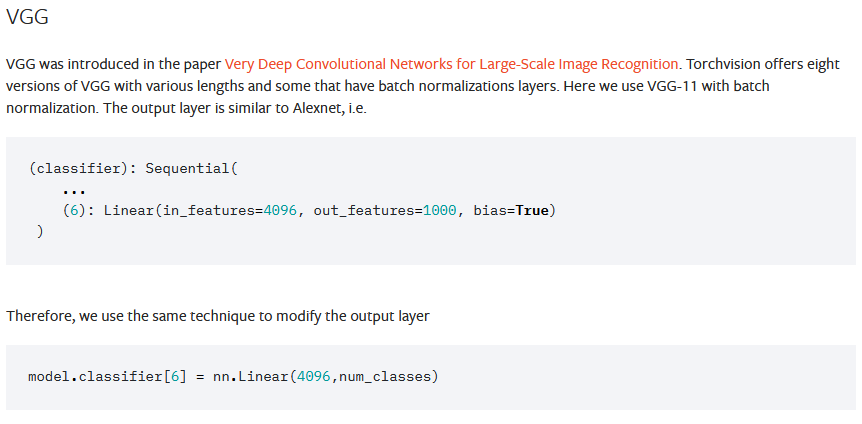

In [14]:
EPOCHS = 5
lr = 0.3 # learning rate
bs = 64
num_classes = 2
loss_func = nn.CrossEntropyLoss()

# here we will later download and assign pre-trained models
learner = models.vgg16()
learner.classifier[6] = nn.Linear(4096,num_classes)

for layers in (learner.classifier)[:15]:
    print(layers)
    layers.trainable = False

# Your nn.Sequential has a .parameters() attribute !
# so the Optimizer find alone all the tensors that require gradients ! 
opt = torch.optim.Adam(learner.parameters(), lr=lr)
#optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

Linear(in_features=25088, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=4096, bias=True)
ReLU(inplace=True)
Dropout(p=0.5, inplace=False)
Linear(in_features=4096, out_features=2, bias=True)


In [15]:
from sklearn.model_selection import train_test_split

class Dataset():
    # A convenience class to have all your data stored at the same place
    # common practice
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i] 

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def flatten(x):
    return x.view(x.shape[0], -1)

def accuracy(output, target):
    return (torch.argmax(output, dim=1) == target).float().mean()

X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.3)
train_dl = DataLoader(Dataset(X_train, y_train), batch_size=32, shuffle=True)
valid_dl = DataLoader(Dataset(X_test, y_test), batch_size=32, shuffle=True)

print(train_images.shape)
print(X_train.shape)
print(X_test.shape)

#plt.imshow(train_images[5].numpy().permute(1, 2, 0))
#print(train_labels[5])

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 181235712 bytes. Buy new RAM!

In [ ]:
# A cool thing is that the train loop doesn't need to change
informations = []
for epoch in range(EPOCHS):
    # put your learner in train mode 
    
    for xb, yb in train_dl:
        # again, practice 
        output = learner(xb)
        loss = loss_func(output,yb)
        # backward pass:
        loss.backward()
        
        # we've removed all the mess into opt: 
        opt.step() #replaces a.weight -= a.weight.grad * lr
        opt.zero_grad()
    # put your learner in eval mode 
    
    with torch.no_grad():
        total_loss, total_acc = 0., 0.
        for xb, yb in valid_dl:
            pred = learner(xb)
            total_loss += loss_func(pred, yb)
            total_acc += accuracy(pred, yb)
        n_entries = len(valid_dl)
        informations.append([epoch, (total_loss/n_entries).item(),(total_acc/n_entries).item() ])
        print('poch', epoch,'loss:', (total_loss/n_entries).item(),'accuracy:', (total_acc/n_entries).item())

In [ ]:
#learner.save('test')

PATH = './cifar_net.pth'
torch.save(learner.state_dict(), PATH)

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(informations)
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","accuracy"])
plt.show()
plt.savefig('loss.png')

In [ ]:
path = "Image"
file = "2.jpg"

img = cv2.imread(os.path.join(path,file))
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()

learner = models.vgg16()
learner.classifier[6] = nn.Linear(4096,num_classes)
learner.load_state_dict(torch.load(PATH))

for e,result in enumerate(ssresults):
        if e < 100:
            x,y,w,h = result
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA).transpose(2,1,0)
            img = np.expand_dims(resized, axis=0)
            out= learner(torch.tensor(img).float())
            if out[0][0] > 0.65:
                print("visage !")
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)  
                break
plt.figure()
plt.imshow(imout)